<a href="https://colab.research.google.com/github/robcovino/MSDAP_notebooks/blob/main/SBI_Tutorial_LD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries we need to import  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import torch

pip install sbi

from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

# Defining our simulator

First, we define our model as the python function `gaussian_model()` to evaluate it.  
In this case our model will be :  
>$x = 1 + \theta + R_x(t)$  

$x$ is our observation and $\theta$ is the parameters. For multiple parameters, the same formula will be applied for each parameter.   
Here $R_x(t)$ is Gaussian noise with zero mean and 1/10 variance.

In [ ]:
def gaussian_model(theta: torch.Tensor):
     return 1.0 + theta + torch.randn(theta.shape) * 0.1

# Defining our prior

Here we define our prior for the inference.  
We will choose a box prior, where each parameter is uncorrelated to the other $p(\theta_1, \theta_2) = p(\theta_1)p(\theta_2)$.  
The box-shaped prior is generated in python with the class `utils.BoxUniform`.

In [ ]:
a_limits = (-2, 2) # Limits of parameter a (lower limit, upper limit)
b_limits = (-2, 2) # Limits of parameter b (lower limit, upper limit)

prior = utils.BoxUniform(low=torch.tensor([a_limits[0], b_limits[0]]), high=torch.tensor([a_limits[1], b_limits[1]]))

To make everything compatible with the sbi library we will use a function that wraps our python model to fit the sbi library standard.  
Therefore we need to call the `prepare_for_sbi()` function with our model and the prior.

In [ ]:
sbi_model, prior = prepare_for_sbi(gaussian_model, prior)

# Generating a synthetic observation  
In the next step, we generate a synthetic observation for which we want to estimate the parameters.  
The variable `true_parameters` contains the parameters we use to simulate the synthetic observation.  
With the `gaussian_model()` function we then simulate our observation

In [ ]:
true_parameters = torch.tensor([1, 1]) # [first parameter, second parameter]
observation = gaussian_model(true_parameters)

In [ ]:
print('The observation we simulated : ', observation)

The observation we simulated :  tensor([1.8555, 2.0894])


# ABC

Draw samples from $p(\theta)$.
Samples are drawn with the python method `.sample()`. The first argument defines how many samples we want to draw. 

In [ ]:
N_samples = 100000  # Number of samples drawn from the prior
prior_samples = prior.sample((N_samples,))

Simulate corresponding observations $x_i \sim p(x_i|\theta)$  

In [ ]:
simulation_results = sbi_model(prior_samples)

In the next step we want to reject all prior samples for which $d(x_0, x) > \epsilon$ holds on.  
For that we have to choose a distance function $d(x_0, x)$ and a threshold value $\epsilon$.
We choose $d(x_0, x) = (x - x_0)^2$.  
This is defined by `torch.sum((simulation_results - observation)**2, dim=1)`.

In [ ]:
epsilon = 0.2  # Treshold value epsilon for ABC

In [ ]:
idx = torch.sum((simulation_results - observation)**2, dim=1) < epsilon

In [ ]:
print('The number of accepted samples : ',  format(float(sum(idx)/N_samples * 100), '.2f'), '%')

The number of accepted samples :  3.87 %


Now we only have to select our prior samples for the simulation which were accepted.  
After that, we can plot our posterior samples with the function provided by the sbi package.

In [ ]:
posterior_samples = prior_samples[idx]

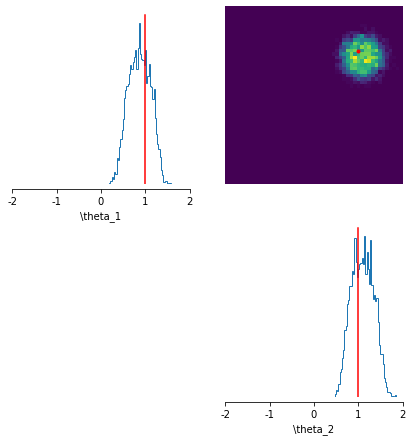

In [ ]:
_ = analysis.pairplot(posterior_samples, limits=[a_limits, b_limits], figsize=(7,7), 
                      points=true_parameters, points_offdiag={'markersize': 6},
                      points_colors='r', labels=[r'\theta_1', r'\theta_2'])

In the figure, we can see three different plots.  
The 2d histogramm in the upper left corner represents the full posterior.  
>$p(\theta_1, \theta_2|x_0)$  

The 1d histogramms can be interpreted as the marginals of the posterior.  
>$p(\theta_1|x_0) = \int_{\theta_2} p(\theta_1, \theta_2|x_0)d\theta_2$  
>$p(\theta_2|x_0) = \int_{\theta_1} p(\theta_1, \theta_2|x_0)d\theta_1$

# Neural Posterior Estimation

In order to perform the likelihood-free inference by fitting the posterior distribution  
wee need just one extra line of code which will do everything for us.  
The method `infer` from the sbi framework, will run the simulations for us, set up and train the desniity estimator.  
Depending on the cpu your computer has this can take a couple of minutes.

In [ ]:
N_simulations = 1000  # Number of simulations used for Neural posterior estimation

In [ ]:
posterior = infer(sbi_model, prior, method='SNPE', num_simulations=N_simulations, num_workers=1)

Running 1000 simulations.:   0%|          | 0/1000 [00:00<?, ?it/s]

Neural network successfully converged after 147 epochs.


# Sampling the posterior for different observed data

In the end, we just have to generate samples from our posterior distribution to plot it.  
Therefore we use again the `.sample()` method for our posterior distribution.

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

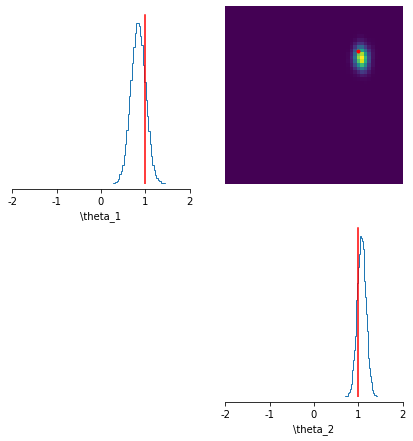

In [ ]:
samples = posterior.sample((100000,), x=observation)
_ = analysis.pairplot(samples, limits=[a_limits, b_limits], figsize=(7,7), 
                      points=true_parameters, points_offdiag={'markersize': 6},
                      points_colors='r', labels=[r'\theta_1', r'\theta_2'])

In the figure, we can see three different plots.  
The 2d histogramm in the upper left corner represents the full posterior.  
>$p(\theta_1, \theta_2|x_0)$  

The 1d histogramms can be interpreted as the marginals of the posterior.  
>$p(\theta_1|x_0) = \int_{\theta_2} p(\theta_1, \theta_2|x_0)d\theta_2$  
>$p(\theta_2|x_0) = \int_{\theta_1} p(\theta_1, \theta_2|x_0)d\theta_1$